In [1]:
import numpy as np
import pandas as pd
import warnings
from prettytable import PrettyTable
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, hamming_loss
from sklearn.model_selection import train_test_split

## 3.1 Pre Requisite ##

### Logistic Regression for Classification ###

In [161]:
class LogisticRegressionScratch():
    def __init__(self, learning_rate, threshold = 0.5, epochs = 700):
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.loss = 0
        self.epochs = epochs
        return
    

    def softmax(self, x):
        exponent = np.dot(x, self.weights) + self.bias
        exponent = np.exp(exponent)
        exponent /= np.sum(exponent, axis=1, keepdims=True)
        return exponent


    def cross_entropy_loss(self, x_train, y_train):           # Vectorised code generated from ChatGPT 
        epsilon = 1e-15
        y_pred = np.clip(self.y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(np.multiply(y_train, np.log(y_pred)))
        return loss
    

    def gradient(self, x_train, y_train):                     # Vectorised code generated from ChatGPT 
        weight_gradient = np.dot(x_train.T, (self.y_pred - y_train)) / x_train.shape[0]
        bias_gradient = np.mean(self.y_pred - y_train, axis=0)
        return weight_gradient, bias_gradient
    

    def forward(self, x_train, y_train):
        self.y_pred = self.softmax(x_train)
        loss = self.cross_entropy_loss(x_train, y_train)
        return loss


    def backward(self, x_train, y_train):
        weight_gradient, bias_gradient = self.gradient(x_train, y_train)
        self.weights -= self.learning_rate * weight_gradient
        self.bias -= self.learning_rate * bias_gradient
        return


    def one_hot_encoding(self, Y):              # generated from ChatGPT
        OneHotEncoding = []
        encoding = []
        
        for i in range(len(Y)):
            encoding = np.zeros(self.k)
            encoding[self.labels_dict[Y[i]]] = 1
            OneHotEncoding.append(encoding)
        return OneHotEncoding


    def max_class(self, y_pred):
        return np.argmax(y_pred)
    

    def fit(self, x_train, y_train):
        labels, counts = np.unique(y_train, return_counts=True)
        self.k = counts.shape[0]
        self.labels_dict = {}
        for i in range(len(labels)):
            self.labels_dict[int(labels[i])] = i


        weights = np.zeros((x_train.shape[1], self.k))
        bias = np.zeros(self.k)
        self.weights = weights
        self.bias = bias
        y_one_hot = self.one_hot_encoding(y_train)

        
        epoch = 0
        self.y_pred = self.softmax(x_train)
        while abs(self.loss-self.cross_entropy_loss(x_train, y_one_hot)) > 1e-8 and epoch < self.epochs:
            self.loss = self.forward(x_train, y_one_hot)
            self.backward(x_train, y_one_hot)
            accuracy = self.evaluation(self.y_pred, y_one_hot)
            # print("Epoch = ",epoch+1, "Loss = ", self.loss, "Accuracy = ", accuracy)
            epoch += 1
        return
    

    def predict(self, x_test, y_test):
        # y_one_hot = self.one_hot_encoding(y_test)
        # self.loss = self.forward(x_test, y_one_hot)
        # self.backward(x_test, y_one_hot)
        self.y_pred = self.softmax(x_test)
        return np.argmax(self.y_pred, axis=1)+3


    def evaluation(self, predicted, actual):
        score = 0
        for i in range(predicted.shape[0]):
            if (self.max_class(actual[i]) == self.max_class(predicted[i])):
                score += 1
        return score/predicted.shape[0]

### Linear Regression for Regression ###

In [3]:
class LinearRegression():
    def __init__(self, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        return


    def loss(self, x_train, y_train):
        y_pred = np.dot(x_train, self.weights[:, np.newaxis])
        temp = np.array([])
        for i in range(y_pred.shape[0]):
            temp = np.append(temp, np.array([y_pred[i]]))
        mse = np.sum(np.square(temp-y_train)) / (2 * x_train.shape[0])
        y_mean = np.mean(temp)
        SS_res = mse * x_train.shape[0]
        SS_tot = np.sum(np.square(y_train-y_mean))
        r_squared = 1 - SS_res / SS_tot
        return mse, r_squared



    def forward(self, x_train, y_train):
        mse, r_squared = self.loss(x_train, y_train)
        return mse, r_squared
    


    def gradient(self, x_train, y_train):
        predictions = np.dot(x_train, self.weights)
        errors = predictions - y_train
        grad = np.dot(errors, x_train) / x_train.shape[0]
        return grad


    def backward(self, x_train, y_train):
        gradient = self.gradient(x_train, y_train)
        self.weights -= self.learning_rate * gradient
        return



    def predict(self, x_test):
        return np.dot(x_test, self.weights)


    def fit(self, x_train, y_train):
        weights = np.random.randn(x_train.shape[1])
        self.weights = weights
        for epoch in range(self.epochs):
            mse, r_sq = self.forward(x_train, y_train)
            self.backward(x_train, y_train)
        return

### Multi-Layer Perceptrons for Classification ###

In [171]:
class MLPClassification():
    def __init__(self, learning_rate, activation = 'Sigmoid', optimiser = 'BGD', num_hidden = 5, num_neurons = 11, epochs = 400):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimiser = optimiser
        self.num_hidden = num_hidden
        self.num_neurons = num_neurons
        self.loss = 0
        self.epochs = epochs
        return


    def cross_entropy_loss(self, layer_input, layer_output):
        epsilon = 1e-15
        y_pred = np.clip(self.y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(np.multiply(layer_output, np.log(y_pred))) / layer_input.shape[0]
        return loss


    def activate(self, layer_input):
        if (self.activation == 'Sigmoid'):
            return 1 / (1+np.exp(-layer_input))
        elif (self.activation == 'Tanh'):
            return (1-np.exp(-2*layer_input)) / (1+np.exp(-2*layer_input))
        elif (self.activation == 'ReLU'):
            return np.maximum(0, layer_input)
        return


    def diff_activate(self, input):
        if (self.activation == 'Sigmoid'):
            sig_val = self.activate(input)
            return sig_val * (1-sig_val)
        
        elif (self.activation == 'Tanh'):
            tanh_val = self.activate(input)
            return 1-tanh_val*tanh_val
        
        elif (self.activation == 'ReLU'):
            return np.where(input <= 0, 0, 1)               # taken from ChatGPT
        return


    # def diff_softmax(self, z):
    #     e_z = np.exp(z)
    #     softmax = e_z / np.sum(e_z)
    #     derivative = softmax * (1 - softmax)
    #     return derivative


    # def softmax(self, x):
    #     exponent = np.exp(x)
    #     exponent /= np.sum(exponent, axis=0, keepdims=True)
    #     return exponent



    def diff_softmax(self, z):
        e_z = np.exp(z - np.max(z))
        softmax = e_z / np.sum(e_z)
        derivative = softmax * (1 - softmax)
        return derivative


    def softmax(self, x):
        x_max = np.max(x, axis=0, keepdims=True)
        exponent = np.exp(x - x_max)
        softmax = exponent / np.sum(exponent, axis=0, keepdims=True)
        return softmax

    
    
    def one_hot_encoding(self, Y):              # generated from ChatGPT
        OneHotEncoding = np.zeros((Y.shape[0], self.k))
        
        for i in range(len(Y)):
            encoding = np.zeros(self.k)
            encoding[self.labels_dict[Y[i]]] = 1
            OneHotEncoding[i] = encoding
        return OneHotEncoding
    


    def gradient(self, layer_input, layer_output):
        
        
        if (self.optimiser == 'SGD'):
            
            indices = np.arange(layer_input.shape[0])
            np.random.shuffle(indices)
            self.loss = 0

            for j in range(layer_input.shape[0]):
                
                self.loss += self.forward_prop(layer_input[j], layer_output[j])
                delta = -(layer_output[j]-self.y_pred)
                dJdw = np.dot(self.a[len(self.a)-1][:, np.newaxis], np.transpose(delta[:, np.newaxis]))
                self.weights[len(self.z)-1] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad

                for i in range(self.num_hidden):
                    delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i])))                    
                    if (i == self.num_hidden-1):
                        dJdw = np.dot(layer_input[j][:, np.newaxis], np.transpose(delta[:, np.newaxis]))
                    else:
                        dJdw = np.dot(self.a[len(self.a)-2-i][:, np.newaxis], np.transpose(delta[:, np.newaxis]))
                    self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                    bias_grad = np.mean(delta, axis = 0)
                    self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad

            return



        if (self.optimiser == 'BGD'):

            self.loss = self.forward_prop(layer_input, layer_output)
            delta = -(layer_output - self.y_pred)
            dJdw = np.dot(np.transpose(self.a[len(self.a)-1]), delta)
            self.weights[len(self.z)-1] -= self.learning_rate*dJdw
            bias_grad = np.mean(delta, axis = 0)
            self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad

            for i in range(self.num_hidden):
                delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i])))
                if (i == self.num_hidden-1):
                    dJdw = np.dot(np.transpose(layer_input), delta)
                else:
                    dJdw = np.dot(np.transpose(self.a[len(self.a)-2-i]), delta)
                self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad


        if (self.optimiser == 'Mini-BGD'):

            batch_size = 50
            self.loss = 0

            for j in range(int(layer_input.shape[0]/batch_size)):

                self.loss += self.forward_prop(layer_input[batch_size*j: batch_size*(j+1), ], layer_output[batch_size*j: batch_size*(j+1), ])
                delta = -(layer_output[batch_size*j: batch_size*(j+1), ] - self.y_pred)
                dJdw = np.dot(np.transpose(self.a[len(self.a)-1]), delta)
                self.weights[len(self.z)-1] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad


                for i in range(self.num_hidden):
                    delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i]))) 
                    if (i == self.num_hidden-1):
                        dJdw = np.dot(np.transpose(layer_input[batch_size*j: batch_size*(j+1), ]), delta)
                    else:
                        dJdw = np.dot(np.transpose(self.a[len(self.a)-2-i]), delta)
                    self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                    bias_grad = np.mean(delta, axis = 0)
                    self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad




    def back_prop(self, layer_input, layer_output):
        self.gradient(layer_input, layer_output)
        return
    

    def forward_prop(self, layer_input, layer_output):
        self.z = []
        self.a = []
        for i in range(self.num_hidden+1):
            z = np.dot(layer_input, self.weights[i])
            if (self.optimiser == 'SGD'):
                z += self.bias[i]
            else:
                for j in range(z.shape[0]):
                    z[j] += self.bias[i]
            
            a = None
            if (i == self.num_hidden):
                a = self.softmax(z)
            else:
                a = self.activate(z)
            
            self.z.append(z)
            if (i != self.num_hidden):
                self.a.append(a)
            layer_input = a

        self.y_pred = layer_input
        loss = self.cross_entropy_loss(layer_output, self.y_pred)
        return abs(loss)


    def initialize_weights_and_biases(self, layer_sizes):
        weights = []
        bias = []
        for i in range(1, len(layer_sizes)):
            input_units = layer_sizes[i - 1]
            output_units = layer_sizes[i]
            weight_matrix = np.random.randn(input_units, output_units) * np.sqrt(2 / input_units)
            bias_vector = np.random.randn(output_units)
            weights.append(weight_matrix)
            bias.append(bias_vector)
        return weights, bias


    def fit(self, x_train, y_train):
        self.labels_dict = {}
        self.k = 6
        for i in range(3, 9):
            self.labels_dict[i] = i-3

        y_one_hot = self.one_hot_encoding(y_train)
        layer_sizes = [x_train.shape[1]]
        for _ in range(self.num_hidden):
            layer_sizes.append(self.num_neurons)
        layer_sizes.append(y_one_hot.shape[1])
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        epoch = 0
        self.y_pred = self.softmax(y_one_hot)
        while abs(self.loss-self.cross_entropy_loss(x_train, y_one_hot)) > 1e-8 and epoch < self.epochs:
            self.back_prop(x_train, y_one_hot)
            epoch += 1
        return



    def predict(self, x_test, y_test):
        y_one_hot = self.one_hot_encoding(y_test)
        self.forward_prop(x_test, y_one_hot)
        return np.argmax(self.y_pred)


    def max_class(self, y_pred):
        return np.argmax(y_pred)


    def evaluation(self, predicted, actual):
        l1 = np.array([])
        l2 = np.array([])
        for i in range(predicted.shape[0]):
            l1 = np.append(l1, np.array([self.max_class(actual[i])]))
            l2 = np.append(l2, np.array([self.max_class(predicted[i])]))
        return accuracy_score(l1, l2), precision_score(l1, l2, average = "weighted", zero_division=True), recall_score(l1, l2, average = "weighted", zero_division=True), f1_score(l1, l2, average = "weighted", zero_division=True)

### Multi-Layer Perceptrons for Regression ###

In [5]:
class MLPRegression():
    def __init__(self, learning_rate, activation = 'Sigmoid', optimiser = 'BGD', num_hidden = 5, num_neurons = 11, epochs = 700):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimiser = optimiser
        self.num_hidden = num_hidden
        self.num_neurons = num_neurons
        self.loss = 0
        self.epochs = epochs
        return


    def predict(self, x_test, y_test):
        self.forward_prop(x_test, y_test)
        return np.squeeze(self.y_pred)


    def activate(self, layer_input):
        if (self.activation == 'Sigmoid'):
            return 1 / (1+np.exp(-layer_input))
        elif (self.activation == 'Tanh'):
            return (1-np.exp(-2*layer_input)) / (1+np.exp(-2*layer_input))
        elif (self.activation == 'ReLU'):
            return np.maximum(0, layer_input)
        return


    def diff_activate(self, input):
        if (self.activation == 'Sigmoid'):
            sig_val = self.activate(input)
            return sig_val * (1-sig_val)
        elif (self.activation == 'Tanh'):
            tanh_val = self.activate(input)
            return 1-tanh_val*tanh_val
        elif (self.activation == 'ReLU'):
            return np.where(input <= 0, 0, 1)               # taken from ChatGPT
        return



    def gradient(self, layer_input, layer_output):
        
        
        if (self.optimiser == 'SGD'):

            indices = np.arange(layer_input.shape[0])
            np.random.shuffle(indices)
    

            for j in range(layer_input.shape[0]):
                
                self.loss = self.forward_prop(layer_input[j], layer_output[j])
                y = layer_output[j].reshape(1, 1)
                delta = -(y-self.y_pred)
                dJdw = np.dot(self.a[len(self.a)-1][:, np.newaxis], delta)
                self.weights[len(self.z)-1] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad

                for i in range(self.num_hidden):
                    delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i])))                    
                    if (i == self.num_hidden-1):
                        dJdw = np.dot(layer_input[j][:, np.newaxis], delta)
                    else:
                        dJdw = np.dot(self.a[len(self.a)-2-i][:, np.newaxis], delta)
                    self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                    bias_grad = np.mean(delta, axis = 0)
                    self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad

            return
        



        if (self.optimiser == 'BGD'):
            
            self.loss = self.forward_prop(layer_input, layer_output)
            y = layer_output.reshape(len(layer_output), 1)
            delta = -(y-self.y_pred)
            dJdw = np.dot(np.transpose(self.a[len(self.a)-1]), delta) / layer_input.shape[0]
            self.weights[len(self.z)-1] -= self.learning_rate*dJdw
            # bias_grad1 = np.transpose(delta[0])
            # bias_grad = np.asarray(bias_grad1).reshape(-1)
            bias_grad = np.mean(delta, axis = 0)
            self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad

            for i in range(self.num_hidden):
                delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i])))
                if (i == self.num_hidden-1):
                    dJdw = np.dot(np.transpose(layer_input), delta) / layer_input.shape[0]                 
                else:
                    dJdw = np.dot(np.transpose(self.a[len(self.a)-2-i]), delta) / layer_input.shape[0]
                self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad
            return
        



        if (self.optimiser == 'Mini-BGD'):

            batch_size = int(layer_input.shape[0]/6)
            for j in range(int(layer_input.shape[0]/batch_size)):

                self.loss = self.forward_prop(layer_input[batch_size*j: batch_size*(j+1), ], layer_output[batch_size*j: batch_size*(j+1), ])
                y = layer_output.reshape(len(layer_output), 1)
                delta = -(y[batch_size*j: batch_size*(j+1), ]-self.y_pred)
                dJdw = np.dot(np.transpose(self.a[len(self.a)-1]), delta) / batch_size
                self.weights[len(self.z)-1] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad


                for i in range(self.num_hidden):
                    delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i])))
                    if (i == self.num_hidden-1):
                        dJdw = np.dot(np.transpose(layer_input[batch_size*j: batch_size*(j+1), ]), delta) / batch_size
                    else:
                        dJdw = np.dot(np.transpose(self.a[len(self.a)-2-i]), delta) / batch_size
                    self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                    bias_grad = np.mean(delta, axis = 0)
                    self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad

            return
        


    def back_prop(self, layer_input, layer_output):
        self.gradient(layer_input, layer_output)
        return
    

    def forward_prop(self, layer_input, layer_output):
        self.z = []
        self.a = []
        for i in range(self.num_hidden+1):
            z = np.dot(layer_input, self.weights[i])

            if (self.optimiser == 'SGD'):
                z += self.bias[i]
            else:
                for j in range(z.shape[0]):
                    z[j] += self.bias[i]
            
            a = self.activate(z)
            self.z.append(z)
            if (i != self.num_hidden):
                self.a.append(a)
            layer_input = a
        self.y_pred = layer_input
        loss = np.mean(np.square(layer_output-self.y_pred))
        return loss


    def loss_compute(self, layer_output):
        y_mean = np.mean(layer_output)
        y_pred = self.y_pred.reshape(layer_output.shape[0])
        numerator = np.sum(np.square(layer_output - y_pred))
        denominator = np.sum(np.square(layer_output - y_mean))
        r_squared = 1 - (numerator / denominator)
        return r_squared



    def initialize_weights_and_biases(self, layer_sizes):
        weights = []
        bias = []
        for i in range(1, len(layer_sizes)):
            input_units = layer_sizes[i - 1]
            output_units = layer_sizes[i]
            weight_matrix = np.random.randn(input_units, output_units) * np.sqrt(2 / input_units)
            bias_vector = np.random.randn(output_units)
            weights.append(weight_matrix)
            bias.append(bias_vector)
        return weights, bias


    def fit(self, x_train, y_train):
        layer_sizes = [x_train.shape[1]]
        for _ in range(self.num_hidden):
            layer_sizes.append(self.num_neurons)
        layer_sizes.append(1)
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        for epoch in range(self.epochs):
            self.back_prop(x_train, y_train)
            # r_sq = self.loss_compute(y_train)
            # print("Epoch = ", epoch+1, "MSE = ", self.loss, "RMSE = ", np.sqrt(self.loss), "R-Squared Error = ", r_sq)
        return

### Data Loading and Preprocessing ###

In [2]:
data_classification = pd.read_csv('./WineQT.csv')
data_classification = data_classification.drop(columns=['Id'])
l = [i for i in data_classification]
data_classification = data_classification.dropna()
data_classification

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


In [3]:
data_classification = np.array([data_classification])
data_classification = data_classification[0]
mean = np.mean(data_classification, axis = 0)
std = np.std(data_classification, axis = 0)
minimum = np.min(data_classification, axis = 0)
maximum = np.max(data_classification, axis = 0)
table = PrettyTable(['Attribute', 'Mean', 'Standard Deviation', 'Minimum Value', 'Maximum'])
for i in range(data_classification.shape[1]-1):
    table.add_row([l[i], mean[i], std[i], minimum[i], maximum[i]])
table

Attribute,Mean,Standard Deviation,Minimum Value,Maximum
fixed acidity,8.311111111111119,1.7468303726275005,4.6,15.9
volatile acidity,0.531338582677165,0.17955459612835611,0.12,1.58
citric acid,0.26836395450568584,0.19659979421574753,0.0,1.0
residual sugar,2.5321522309711257,1.3553241971435854,0.9,15.5
chlorides,0.08693263342082211,0.04724665655215519,0.012,0.611
free sulfur dioxide,15.615485564304462,10.246001115067603,1.0,68.0
total sulfur dioxide,45.91469816272966,32.767786779941396,6.0,289.0
density,0.9967304111986008,0.0019242248343795283,0.99007,1.00369
pH,3.3110148731408593,0.15659551281704343,2.74,4.01
sulphates,0.6577077865266842,0.17032415803626072,0.33,2.0


In [4]:
X = np.zeros((data_classification.shape[0], data_classification.shape[1]-1))
for i in range(data_classification.shape[1]-1):
    X[:, i] = data_classification[:, i]
y = data_classification[:, data_classification.shape[1]-1]
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.3)
x_test_c, x_val_c, y_test_c, y_val_c = train_test_split(x_test_c, y_test_c, test_size=0.33)

In [5]:
data_regression = pd.read_csv('./HousingData.csv')
l = [i for i in data_regression]
mean_result = data_regression.mean(skipna=True)
std_result = data_regression.std(skipna=True)

data_types = data_regression.dtypes
for i in range(len(l)):
    if (data_types[i] == 'object' or data_types[i] == 'bool'):
        continue
    data_regression = data_regression.fillna({l[i]: mean_result[l[i]]})
data_regression

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.200000,4.0900,1,296,15.3,396.90,4.980000,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.900000,4.9671,2,242,17.8,396.90,9.140000,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.100000,4.9671,2,242,17.8,392.83,4.030000,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.800000,6.0622,3,222,18.7,394.63,2.940000,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.200000,6.0622,3,222,18.7,396.90,12.715432,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.100000,2.4786,1,273,21.0,391.99,12.715432,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.700000,2.2875,1,273,21.0,396.90,9.080000,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.000000,2.1675,1,273,21.0,396.90,5.640000,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.300000,2.3889,1,273,21.0,393.45,6.480000,22.0


In [6]:
data_regression = np.array([data_regression])
data_regression = data_regression[0]
mean = np.mean(data_regression, axis = 0)
std = np.std(data_regression, axis = 0)
minimum = np.min(data_regression, axis = 0)
maximum = np.max(data_regression, axis = 0)
table = PrettyTable(['Attribute', 'Mean', 'Standard Deviation', 'Minimum Value', 'Maximum'])
for i in range(data_regression.shape[1]-1):
    table.add_row([l[i], mean[i], std[i], minimum[i], maximum[i]])
table

Attribute,Mean,Standard Deviation,Minimum Value,Maximum
CRIM,3.611873971193416,8.537321779593817,0.00632,88.9762
ZN,11.211934156378598,22.898390901831366,0.0,100.0
INDUS,11.08399176954735,6.6925417540998104,0.46,27.74
CHAS,0.06995884773662546,0.24998576709269318,0.0,1.0
NOX,0.5546950592885372,0.11576311540656153,0.385,0.871
RM,6.284634387351787,0.7019225143345692,3.561,8.78
AGE,68.51851851851853,27.412338662278373,2.9,100.0
DIS,3.795042687747034,2.103628356344459,1.1296,12.1265
RAD,9.549407114624506,8.698651117790645,1.0,24.0
TAX,408.2371541501976,168.3704950393814,187.0,711.0


In [7]:
data_regression = np.array([data_regression])
data_regression = data_regression[0]

mean = np.mean(data_regression, axis = 0)
std = np.std(data_regression, axis = 0)
data_regression -= mean
data_regression /= std

X = np.zeros((data_regression.shape[0], data_regression.shape[1]-1))
for i in range(data_regression.shape[1]-1):
    X[:, i] = data_regression[:, i]
y = data_regression[:, data_regression.shape[1]-1]

x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(X, y, test_size=0.3, random_state=42)
x_test_r, x_val_r, y_test_r, y_val_r = train_test_split(x_test_r, y_test_r, test_size=0.33, random_state=42)

### Hyperparameter Tuning ###

In [178]:
from sklearn.metrics import r2_score

r2_min = -1
r = []
for learning_rate in range(10):
    for epochs in range(100, 1000, 300):
        lr = LinearRegression(learning_rate=0.001+learning_rate*0.01, epochs=epochs)
        lr.fit(x_train_r, y_train_r)
        r2 = r2_score(y_test_r, lr.predict(x_test_r))
        if (r2 > r2_min):
            r = [0.001+learning_rate*0.01, epochs]
print("Best Performing Set of Hyperparameters for Linear Regression are: Learning Rate = ", r[0], "Epochs = ", r[1])

Best Performing Set of Hyperparameters for Linear Regression are: Learning Rate =  0.091 Epochs =  700


##### Note - Best performing set of Hyperparameters are hardcoded for each class when the object for that particular class is instantiated. In Case of MLPs and Logistic Regression, Best performing set of Hyperparamaters are taken from the previous assignment. #####

## 3.2 Bagging ##

In [173]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')



def bagging_1(model, num_estimators, sample_fraction, bootstrap, voting_mechanism):

    le = LabelEncoder()
    predictions = np.zeros((x_test_c.shape[0], num_estimators))
    labels, counts = np.unique(y_train_c, return_counts=True)
    predicted_prob = np.zeros((num_estimators, x_test_c.shape[0], counts.shape[0]))


    indices = np.arange(len(x_train_c))
    len_init = len(x_train_c)

    for i in range(num_estimators):

        X = None
        Y = None
        index_l = np.random.choice(len(indices), int(len_init * sample_fraction), replace = bootstrap)
        if (bootstrap is True):                     # perform sampling with replacement
            X = x_train_c[index_l]
            Y = y_train_c[index_l]
        else:
            X = x_train_c[index_l]
            Y = y_train_c[index_l]
            indices = np.delete(indices, index_l)


        model.fit(X, Y)
        if (isinstance(model, LogisticRegressionScratch)):
            predictions[:, i] = model.predict(x_test_c, y_test_c)
            if (model.y_pred.shape != (x_test_c.shape[0], 6)):
                temp = np.zeros((x_test_c.shape[0], 6))
                for j in range(model.y_pred.shape[1]):
                    temp[:, j] = model.y_pred[:, j]
                predicted_prob[i] = temp
            else:
                predicted_prob[i] = model.y_pred

        elif (isinstance(model, DecisionTreeClassifier)):
            predictions[:, i] = model.predict(x_test_c)
            for j in range(predictions.shape[0]):
                predicted_prob[i, j, int(predictions[j, i])-3] = 1
        
        elif (isinstance(model, MLPClassification)):
            predictions[:, i] = model.predict(x_test_c, y_test_c)
            if (model.y_pred.shape != (x_test_c.shape[0], 6)):
                temp = np.zeros((x_test_c.shape[0], 6))
                for j in range(model.y_pred.shape[1]):
                    temp[:, j] = model.y_pred[:, j]
                predicted_prob[i] = temp
            else:
                predicted_prob[i] = model.y_pred

    

    outputs = np.zeros(y_test_c.shape[0])
    for i in range(x_test_c.shape[0]):
        if (voting_mechanism == 'hard'):
            
            votes = np.zeros(counts.shape[0])
            for j in range(num_estimators):
                votes[np.argmax(predicted_prob[j][i])] += 1
            outputs[i] = np.argmax(votes)+3

        else:
            votes = np.zeros((counts.shape[0], counts.shape[0]))
            for j in range(num_estimators):
                votes[np.argmax(predicted_prob[j][i])] = predicted_prob[j][i]
            sum_prob = np.sum(votes, axis = 0)
            outputs[i] = np.argmax(sum_prob)+3

    return accuracy_score(outputs, y_test_c)


base_estimators = [LogisticRegressionScratch(learning_rate=0.091, threshold=0.5, epochs=700), DecisionTreeClassifier(), MLPClassification(learning_rate=0.071)]
sample_fraction = 0.2
bootstrap = True
voting_mechanism = 'hard'

for model in base_estimators:
    accuracy = bagging_1(model, 3, sample_fraction, bootstrap, voting_mechanism)
    print(accuracy)

0.0
0.5152838427947598
0.43231441048034935


In [283]:
from sklearn.metrics import accuracy_score, r2_score
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')



def bagging_2(model, num_estimators, sample_fraction, bootstrap, voting_mechanism):

    predictions = np.zeros((x_test_r.shape[0], num_estimators))
    labels, counts = np.unique(y_train_r, return_counts=True)
    predicted_prob = np.zeros((num_estimators, x_test_r.shape[0]))

    for i in range(num_estimators):

        X = None
        Y = None
        if (bootstrap is True):                     # perform sampling with replacement
            index_l = np.random.choice(len(x_train_r), int(len(x_train_r) * sample_fraction), replace = True)
            X = x_train_r[index_l]
            Y = y_train_r[index_l]
        else:                                       # perform sampling without replacement
            index_l = np.random.choice(len(x_train_r), int(len(x_train_r) * sample_fraction), replace = False)
            X = x_train_r[index_l]
            Y = y_train_r[index_l]

        model.fit(X, Y)
        if (isinstance(model, LinearRegression)):
            predictions[:, i] = model.predict(x_test_r)
            predicted_prob[i] = r2_score(y_val_r, model.predict(x_val_r))
            # predicted_prob[i] = model.y_pred

        elif (isinstance(model, DecisionTreeRegressor)):
            predictions[:, i] = model.predict(x_test_r)
            predicted_prob[i] = r2_score(y_val_r, model.predict(x_val_r))
            # for j in range(predictions.shape[0]):
                # predicted_prob[i, j, int(predictions[j, i])-3] = 1
        
        elif (isinstance(model, MLPRegression)):
            predictions[:, i] = model.predict(x_test_r, y_test_r)
            predicted_prob[i] = r2_score(y_val_r, model.predict(x_val_r, y_val_r))
            # predicted_prob[i] = model.y_pred


    outputs = np.zeros(y_test_r.shape[0])
    for i in range(x_test_r.shape[0]):
        if (voting_mechanism == 'hard'):
            outputs[i] = np.mean(predictions[i])

        else:

            sum = 0
            sum_prob = 0
            for j in range(num_estimators):
                sum += predicted_prob[j][i]*predictions[i][j]
                sum_prob += predicted_prob[j][i]
            outputs[i] = sum / sum_prob

    return r2_score(outputs, y_test_r)


base_estimators = [LinearRegression(learning_rate=0.091, epochs=700), DecisionTreeRegressor(), MLPRegression(learning_rate=0.091)]
sample_fraction = 1
bootstrap = True
voting_mechanism = 'soft'

for model in base_estimators:
    r2 = bagging_2(model, 3, sample_fraction, bootstrap, voting_mechanism)

#### Hyperparameter Tuning for Bagging ####

In [368]:
import time

accuracies = []
time_taken = []

voting_mechanism = ['hard', 'soft']
sample_fraction = [0.15, 0.25, 0.5, 0.75, 1]
bootstrapping = [False, True]
num_estimators = [3, 5, 7]
base_model = [LogisticRegressionScratch(learning_rate=0.091, threshold=0.5, epochs=700), DecisionTreeClassifier(), MLPClassification(learning_rate=0.071)]

for model in base_model:
    for frac in sample_fraction:
        for bootstrap in bootstrapping:
            for n in num_estimators:
                for vote in voting_mechanism:
                    if (frac * n > 1):
                        continue
                    print(frac, bootstrap, n, vote)
                    start_time = time.time()
                    accuracy = bagging_1(model, n, frac, bootstrap, vote)
                    
                    if (isinstance(model, LogisticRegressionScratch)):
                        accuracies.append([accuracy, frac, bootstrap, n, vote, "Logistic"])
                    elif (isinstance(model, DecisionTreeClassifier)):
                        accuracies.append([accuracy, frac, bootstrap, n, vote, "DTree"])
                    elif (isinstance(model, MLPClassification)):
                        accuracies.append([accuracy, frac, bootstrap, n, vote, "MLP"])
                        
                    end_time = time.time()
                    time_taken.append(end_time-start_time)

0.15 False 3 hard
0.15 False 3 soft
0.15 False 5 hard
0.15 False 5 soft
0.15 True 3 hard
0.15 True 3 soft
0.15 True 5 hard
0.15 True 5 soft
0.25 False 3 hard
0.25 False 3 soft
0.25 True 3 hard
0.25 True 3 soft
0.15 False 3 hard
0.15 False 3 soft
0.15 False 5 hard
0.15 False 5 soft
0.15 True 3 hard
0.15 True 3 soft
0.15 True 5 hard
0.15 True 5 soft
0.25 False 3 hard
0.25 False 3 soft
0.25 True 3 hard
0.25 True 3 soft
0.15 False 3 hard
0.15 False 3 soft
0.15 False 5 hard
0.15 False 5 soft
0.15 True 3 hard
0.15 True 3 soft
0.15 True 5 hard
0.15 True 5 soft
0.25 False 3 hard
0.25 False 3 soft
0.25 True 3 hard
0.25 True 3 soft


In [369]:
l = accuracies
l.sort()
print("Best Performing Set of Hyperparameters are sample fraction = ", l[-1][1], "Bootstrapping = ", l[-1][2], "Number of Estimators = ", l[-1][3], "Voting Mechanism = ", l[-1][4], "Model = ", l[-1][5])

Best Performing Set of Hyperparameters are sample fraction =  0.15 Bootstrapping =  True Number of Estimators =  3 Voting Mechanism =  hard Model =  DTree


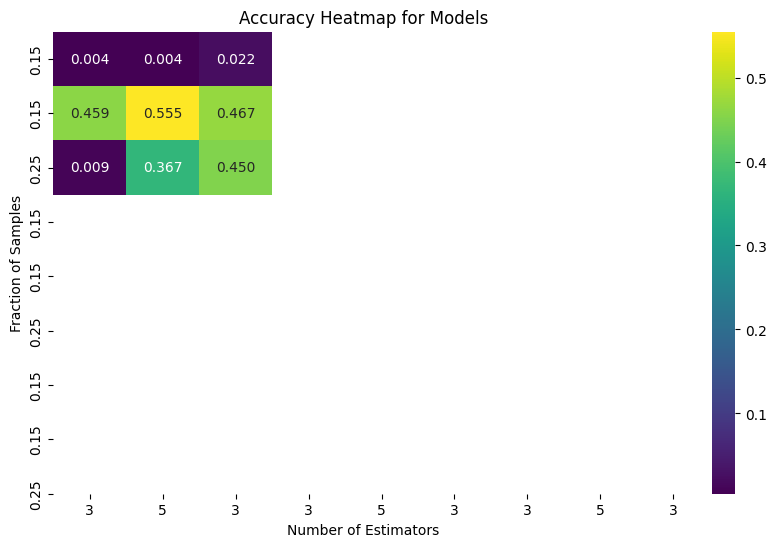

In [227]:
heat_map = []

for model in base_model:
    for frac in sample_fraction:
        for n in num_estimators:
            if (frac * n > 1):
                continue

            accuracy = bagging_1(model, n, frac, True, 'hard')
            if (isinstance(model, LogisticRegressionScratch)):
                heat_map.append([accuracy, frac, n, "Logistic"])
            elif (isinstance(model, DecisionTreeClassifier)):
                heat_map.append([accuracy, frac, n, "DTree"])
            elif (isinstance(model, MLPClassification)):
                heat_map.append([accuracy, frac, n, "MLP"])

accuracy_matrix = [[], [], []]

for i in range(len(heat_map)):
    if (heat_map[i][3] == 'Logistic'):
        accuracy_matrix[0].append(heat_map[i][0])
    elif (heat_map[i][3] == 'DTree'):
        accuracy_matrix[1].append(heat_map[i][0])
    elif (heat_map[i][3] == 'MLP'):
        accuracy_matrix[2].append(heat_map[i][0])


plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_matrix, cmap='viridis', annot=True, fmt=".3f", xticklabels=[heat_map[i][2] for i in range(len(heat_map))], yticklabels=[heat_map[i][1] for i in range(len(heat_map))])
plt.xlabel('Number of Estimators')
plt.ylabel('Fraction of Samples')
plt.title('Accuracy Heatmap for Models')
plt.show()

In [370]:
clf = LogisticRegressionScratch(learning_rate=0.091, threshold=0.5, epochs=700)
clf.fit(x_train_c, y_train_c)
a1 = accuracy_score(y_test_c, clf.predict(x_test_c, y_test_c))


clf = DecisionTreeClassifier()
clf.fit(x_train_c, y_train_c)
a2 = accuracy_score(y_test_c, clf.predict(x_test_c))


clf = MLPClassification(learning_rate=0.071)
clf.fit(x_train_c, y_train_c)
clf.predict(x_test_c, y_test_c)
y_pred = np.zeros(y_test_c.shape[0])
for i in range(clf.y_pred.shape[0]):
    y_pred[i] = np.argmax(clf.y_pred[i])
a3 = accuracy_score(y_test_c, y_pred+3)

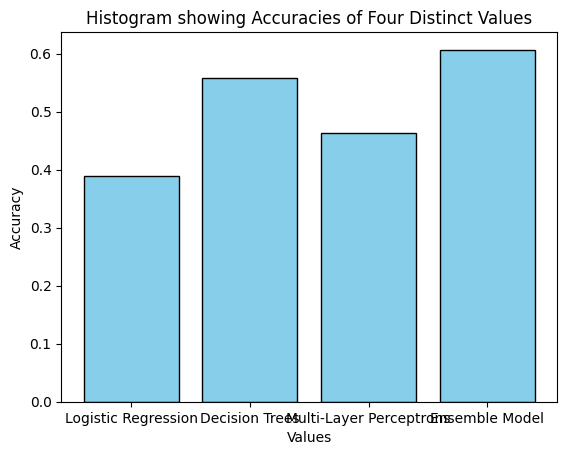

In [371]:
values = ['Logistic Regression', 'Decision Trees', 'Multi-Layer Perceptrons', 'Ensemble Model']
counts = [a1, a2, a3, l[-1][0]]

# Plotting the bar chart
plt.bar(values, counts, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Accuracy')
plt.title('Histogram showing Accuracies of Four Distinct Values')
plt.show()

In [373]:
import time

r2 = []
time_taken = []

voting_mechanism = ['hard', 'soft']
sample_fraction = [0.15, 0.25, 0.5, 0.75, 1]
bootstrapping = [False, True]
num_estimators = [3, 5, 7]
base_model = [LinearRegression(learning_rate=0.091, epochs=700), DecisionTreeRegressor(), MLPRegression(learning_rate=0.091)]

for model in base_model:
    for frac in sample_fraction:
        for bootstrap in bootstrapping:
            for n in num_estimators:
                for vote in voting_mechanism:
                    if (frac * n > 1):
                        continue
                    print(frac, bootstrap, n, vote)
                    start_time = time.time()
                    r2_s = bagging_2(model, n, frac, bootstrap, vote)
                    
                    if (isinstance(model, LinearRegression)):
                        r2.append([r2_s, frac, bootstrap, n, vote, "Linear"])
                    elif (isinstance(model, DecisionTreeRegressor)):
                        r2.append([r2_s, frac, bootstrap, n, vote, "DTree"])
                    elif (isinstance(model, MLPRegression)):
                        r2.append([r2_s, frac, bootstrap, n, vote, "MLP"])
                        
                    end_time = time.time()
                    time_taken.append(end_time-start_time)

0.15 False 3 hard
0.15 False 3 soft
0.15 False 5 hard
0.15 False 5 soft
0.15 True 3 hard
0.15 True 3 soft
0.15 True 5 hard
0.15 True 5 soft
0.25 False 3 hard
0.25 False 3 soft
0.25 True 3 hard
0.25 True 3 soft
0.15 False 3 hard
0.15 False 3 soft
0.15 False 5 hard
0.15 False 5 soft
0.15 True 3 hard
0.15 True 3 soft
0.15 True 5 hard
0.15 True 5 soft
0.25 False 3 hard
0.25 False 3 soft
0.25 True 3 hard
0.25 True 3 soft
0.15 False 3 hard
0.15 False 3 soft
0.15 False 5 hard
0.15 False 5 soft
0.15 True 3 hard
0.15 True 3 soft
0.15 True 5 hard
0.15 True 5 soft
0.25 False 3 hard
0.25 False 3 soft
0.25 True 3 hard
0.25 True 3 soft


In [374]:
l = r2
l.sort()
print("Best Performing Set of Hyperparameters are sample fraction = ", l[-1][1], "Bootstrapping = ", l[-1][2], "Number of Estimators = ", l[-1][3], "Voting Mechanism = ", l[-1][4], "Model = ", l[-1][5])

Best Performing Set of Hyperparameters are sample fraction =  0.15 Bootstrapping =  False Number of Estimators =  5 Voting Mechanism =  soft Model =  DTree


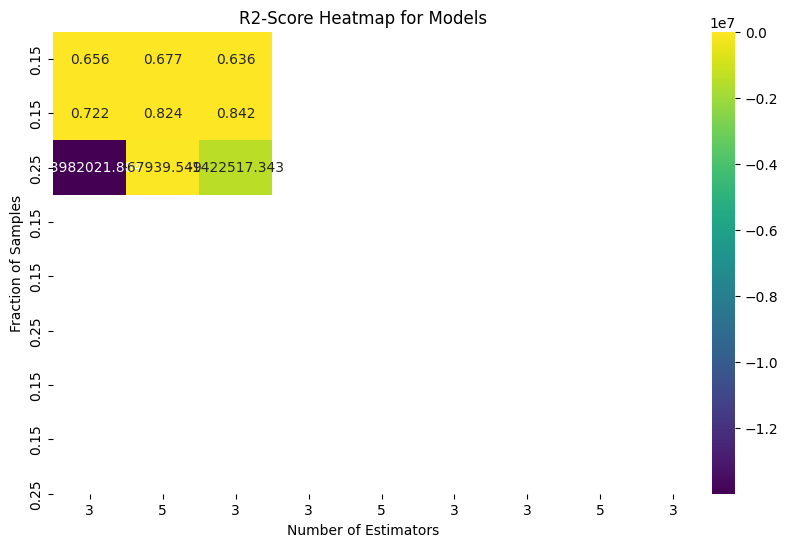

In [376]:
heat_map = []

for model in base_model:
    for frac in sample_fraction:
        for n in num_estimators:
            if (frac * n > 1):
                continue
            
            r2_s = bagging_2(model, n, frac, True, 'hard')
            if (isinstance(model, LinearRegression)):
                heat_map.append([r2_s, frac, n, "Linear"])
            elif (isinstance(model, DecisionTreeRegressor)):
                heat_map.append([r2_s, frac, n, "DTree"])
            elif (isinstance(model, MLPRegression)):
                heat_map.append([r2_s, frac, n, "MLP"])

accuracy_matrix = [[], [], []]

for i in range(len(heat_map)):
    if (heat_map[i][3] == 'Linear'):
        accuracy_matrix[0].append(heat_map[i][0])
    elif (heat_map[i][3] == 'DTree'):
        accuracy_matrix[1].append(heat_map[i][0])
    elif (heat_map[i][3] == 'MLP'):
        accuracy_matrix[2].append(heat_map[i][0])


plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_matrix, cmap='viridis', annot=True, fmt=".3f", xticklabels=[heat_map[i][2] for i in range(len(heat_map))], yticklabels=[heat_map[i][1] for i in range(len(heat_map))])
plt.xlabel('Number of Estimators')
plt.ylabel('Fraction of Samples')
plt.title('R2-Score Heatmap for Models')
plt.show()

In [361]:
clf = LinearRegression(learning_rate=0.091, epochs=700)
clf.fit(x_train_r, y_train_r)
a1 = r2_score(y_test_r, clf.predict(x_test_r))


clf = DecisionTreeRegressor()
clf.fit(x_train_r, y_train_r)
a2 = r2_score(y_test_r, clf.predict(x_test_r))


clf = MLPRegression(learning_rate=0.071)
clf.fit(x_train_r, y_train_r)

a3 = r2_score(y_test_r, clf.predict(x_test_r, y_test_r))

0.705698681118804 0.7395901926668984 -0.05745820870930829 0.8083645682090632


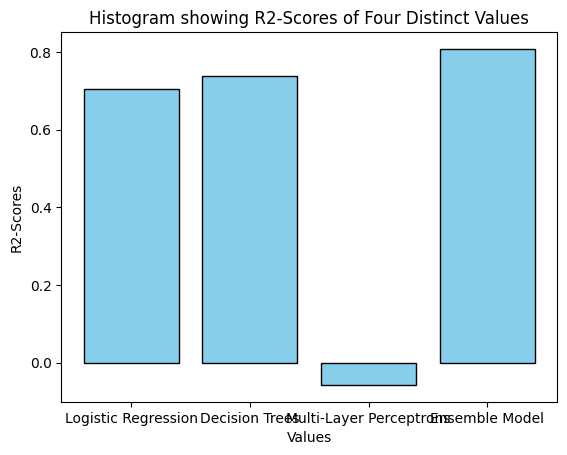

In [362]:
values = ['Logistic Regression', 'Decision Trees', 'Multi-Layer Perceptrons', 'Ensemble Model']
counts = [a1, a2, a3, l[-1][0]]

print(a1, a2, a3, l[-1][0])
# Plotting the bar chart
plt.bar(values, counts, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('R2-Scores')
plt.title('Histogram showing R2-Scores of Four Distinct Values')
plt.show()

## 3.3 Stacking ## 

In [402]:
# Stacking and Blending for Classification


from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')


def stacking(n_folds, x_train, y, level_0_estimators, level_1_estimators):
    kf = KFold(n_splits=n_folds, random_state=None)
    le = LabelEncoder()
    meta_features = np.zeros((len(y), len(level_0_estimators)))

    for train_index, test_index in kf.split(x_train):

        X_train, X_test = x_train[train_index], x_train[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        for i, model in enumerate(level_0_estimators):
            model.fit(X_train, y_train)

            if (isinstance(model, LogisticRegressionScratch)):
                meta_features[test_index, i] = model.predict(X_test, y_test)

            elif (isinstance(model, DecisionTreeClassifier)):
                meta_features[test_index, i] = model.predict(X_test)
            
            elif (isinstance(model, MLPClassifier)):
                meta_features[test_index, i] = model.predict(X_test)

            

    meta_features_test = np.zeros((y_test_c.shape[0], len(level_0_estimators)))
    for i, model in enumerate(level_0_estimators):
        if (isinstance(model, LogisticRegressionScratch)):
            meta_features_test[:, i] = model.predict(x_test_c, y_test_c)

        elif (isinstance(model, DecisionTreeClassifier)):
            meta_features_test[:, i] = model.predict(x_test_c)
        
        elif (isinstance(model, MLPClassifier)):
            meta_features_test[:, i] = model.predict(x_test_c)



    for model in level_1_estimators:
        model.fit(meta_features, le.fit_transform(y))




    # retrain x_train, y_train on entire training dataset
    for model in level_0_estimators:
        model.fit(x_train, y)


    # predict values of x_test_c on the base models 
    meta_train = np.zeros((x_test_c.shape[0], len(level_0_estimators)))
    for i in range(len(level_0_estimators)):
        if (isinstance(level_0_estimators[i], LogisticRegressionScratch)):
            meta_train[:, i] = level_0_estimators[i].predict(x_test_c, y_test_c)

        elif (isinstance(level_0_estimators[i], DecisionTreeClassifier)):
            meta_train[:, i] = level_0_estimators[i].predict(x_test_c)
        
        elif (isinstance(level_0_estimators[i], MLPClassifier)):
            meta_train[:, i] = level_0_estimators[i].predict(x_test_c)



    predictions = np.zeros(y_test_c.shape[0])
    for model in level_1_estimators:

        if (isinstance(model, LogisticRegressionScratch)):
            y_pred = model.predict(meta_train, y_test_c)

        elif (isinstance(model, DecisionTreeClassifier)):
            y_pred = model.predict(meta_train)

        # y_pred = model.predict(meta_train)
        predictions += (y_pred / len(level_1_estimators))

    for i in range(predictions.shape[0]):
        predictions[i] = int(predictions[i])
    return accuracy_score(predictions, y_test_c)


def blending(x_train, y, level_0_estimators, level_1_estimators):

    x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.125, random_state=None)

    le = LabelEncoder()
    predictions = np.zeros((x_val.shape[0], len(level_0_estimators)))
    for i in range(len(level_0_estimators)):
        level_0_estimators[i].fit(x_train, y_train)

        if (isinstance(level_0_estimators[i], LogisticRegressionScratch)):
            y_pred = level_0_estimators[i].predict(x_val, y_val)

        elif (isinstance(level_0_estimators[i], DecisionTreeClassifier)):
            y_pred = level_0_estimators[i].predict(x_val)
        
        elif (isinstance(level_0_estimators[i], MLPClassifier)):
            y_pred = level_0_estimators[i].predict(x_val)

        # y_pred = level_0_estimators[i].predict(x_val)
        predictions[:, i] = y_pred

    meta_features_test = np.zeros((y_test_c.shape[0], len(level_0_estimators)))
    for i, model in enumerate(level_0_estimators):

        if (isinstance(model, LogisticRegressionScratch)):
            meta_features_test[:, i] = model.predict(x_test_c, y_test_c)

        elif (isinstance(model, DecisionTreeClassifier)):
            meta_features_test[:, i] = model.predict(x_test_c)

        elif (isinstance(model, MLPClassifier)):
            meta_features_test[:, i] = model.predict(x_test_c)



    final_predictions = np.zeros(y_test_c.shape[0])
    for model in level_1_estimators:
        model.fit(predictions, le.fit_transform(y_val))

        if (isinstance(model, LogisticRegressionScratch)):
            pred = model.predict(meta_features_test, y_test_c)

        elif (isinstance(model, DecisionTreeClassifier)):
            pred = model.predict(meta_features_test)

        final_predictions += (pred / len(level_1_estimators))

    for i in range(final_predictions.shape[0]):
        final_predictions[i] = int(final_predictions[i])

    return accuracy_score(final_predictions, le.fit_transform(y_test_c))




def stacking_classifier(level_0_estimators, level_1_estimators, stacking_methods):
    if stacking_methods == 'Stacking':
        a = stacking(10, x_train_c, y_train_c, level_0_estimators=level_0_estimators, level_1_estimators=level_1_estimators)
        return a
    else:
        a = blending(x_train_c, y_train_c, level_0_estimators=level_0_estimators, level_1_estimators=level_1_estimators)
        return a


# level_0_estimators = [LogisticRegression(), DecisionTreeClassifier(), MLPClassifier()]
# level_1_estimators = [LogisticRegression(), DecisionTreeClassifier()]

level_0_estimators = [LogisticRegressionScratch(learning_rate=0.091, threshold=0.5, epochs=700), DecisionTreeClassifier(), MLPClassification(learning_rate=0.071)]
level_1_estimators = [LogisticRegressionScratch(learning_rate=0.091, threshold=0.5, epochs=700), DecisionTreeClassifier()]
# stacking_methods = 'Stacking'
stacking_methods = 'Blending'
stacking_classifier(level_0_estimators, level_1_estimators, stacking_methods)

0.5327510917030568

In [392]:
# Stacking and Blending for Regression


from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


def stacking_1(n_folds, x_train, y, level_0_estimators, level_1_estimators):
    kf = KFold(n_splits=n_folds, random_state=None)
    meta_features = np.zeros((len(y), len(level_0_estimators)))

    for train_index, test_index in kf.split(x_train):

        X_train, X_test = x_train[train_index], x_train[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        for i, model in enumerate(level_0_estimators):
            model.fit(X_train, y_train)

            if (isinstance(model, LinearRegression)):
                meta_features[test_index, i] = model.predict(X_test)

            elif (isinstance(model, DecisionTreeRegressor)):
                meta_features[test_index, i] = model.predict(X_test)
            
            elif (isinstance(model, MLPRegressor)):
                meta_features[test_index, i] = model.predict(X_test)

            

    meta_features_test = np.zeros((y_test_r.shape[0], len(level_0_estimators)))
    for i, model in enumerate(level_0_estimators):
        if (isinstance(model, LinearRegression)):
            meta_features_test[:, i] = model.predict(x_test_r)

        elif (isinstance(model, DecisionTreeRegressor)):
            meta_features_test[:, i] = model.predict(x_test_r)
        
        elif (isinstance(model, MLPRegressor)):
            meta_features_test[:, i] = model.predict(x_test_r)



    for model in level_1_estimators:
        model.fit(meta_features, y)




    # retrain x_train, y_train on entire training dataset
    for model in level_0_estimators:
        model.fit(x_train, y)


    # predict values of x_test_c on the base models 
    meta_train = np.zeros((x_test_r.shape[0], len(level_0_estimators)))
    for i in range(len(level_0_estimators)):
        if (isinstance(level_0_estimators[i], LinearRegression)):
            meta_train[:, i] = level_0_estimators[i].predict(x_test_r)

        elif (isinstance(level_0_estimators[i], DecisionTreeRegressor)):
            meta_train[:, i] = level_0_estimators[i].predict(x_test_r)
        
        elif (isinstance(level_0_estimators[i], MLPRegressor)):
            meta_train[:, i] = level_0_estimators[i].predict(x_test_r)



    predictions = np.zeros(y_test_r.shape[0])
    for model in level_1_estimators:

        if (isinstance(model, LinearRegression)):
            y_pred = model.predict(meta_train)

        elif (isinstance(model, DecisionTreeRegressor)):
            y_pred = model.predict(meta_train)

        # y_pred = model.predict(meta_train)
        predictions += (y_pred / len(level_1_estimators))

    for i in range(predictions.shape[0]):
        predictions[i] = int(predictions[i])
    print(mean_squared_error(predictions, y_test_r))
    return


def blending_1(x_train, y, level_0_estimators, level_1_estimators):

    x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.125, random_state=None)

    predictions = np.zeros((x_val.shape[0], len(level_0_estimators)))
    for i in range(len(level_0_estimators)):
        level_0_estimators[i].fit(x_train, y_train)

        if (isinstance(level_0_estimators[i], LinearRegression)):
            y_pred = level_0_estimators[i].predict(x_val)

        elif (isinstance(level_0_estimators[i], DecisionTreeRegressor)):
            y_pred = level_0_estimators[i].predict(x_val)
        
        elif (isinstance(level_0_estimators[i], MLPRegressor)):
            y_pred = level_0_estimators[i].predict(x_val)

        # y_pred = level_0_estimators[i].predict(x_val)
        predictions[:, i] = y_pred

    meta_features_test = np.zeros((y_test_r.shape[0], len(level_0_estimators)))
    for i, model in enumerate(level_0_estimators):

        if (isinstance(model, LinearRegression)):
            meta_features_test[:, i] = model.predict(x_test_r)

        elif (isinstance(model, DecisionTreeRegressor)):
            meta_features_test[:, i] = model.predict(x_test_r)

        elif (isinstance(model, MLPRegressor)):
            meta_features_test[:, i] = model.predict(x_test_r)



    final_predictions = np.zeros(y_test_r.shape[0])
    for model in level_1_estimators:
        model.fit(predictions, y_val)

        if (isinstance(model, LinearRegression)):
            pred = model.predict(meta_features_test)

        elif (isinstance(model, DecisionTreeRegressor)):
            pred = model.predict(meta_features_test)

        final_predictions += (pred / len(level_1_estimators))

    for i in range(final_predictions.shape[0]):
        final_predictions[i] = int(final_predictions[i])

    return r2_score(final_predictions, y_test_r)




def stacking_regressor(level_0_estimators, level_1_estimators, stacking_methods):
    if stacking_methods == 'Stacking':
        return stacking_1(10, x_train_r, y_train_r, level_0_estimators=level_0_estimators, level_1_estimators=level_1_estimators)
    else:
        return blending_1(x_train_r, y_train_r, level_0_estimators=level_0_estimators, level_1_estimators=level_1_estimators)


# level_0_estimators = [LogisticRegression(), DecisionTreeClassifier(), MLPClassifier()]
# level_1_estimators = [LogisticRegression(), DecisionTreeClassifier()]
level_0_estimators = [LinearRegression(learning_rate=0.091, epochs=700), DecisionTreeRegressor(), MLPRegression(learning_rate=0.091)]
level_1_estimators = [LinearRegression(learning_rate=0.091, epochs=700), DecisionTreeRegressor()]
stacking_methods = 'Stacking'
# stacking_methods = 'Blending'
stacking_regressor(level_0_estimators, level_1_estimators, stacking_methods)

0.3031607283830425


#### Hyperparameter Tuning for Stacking ####

In [413]:
import time

accuracies = []
time_taken = []

stacking_methods = ['Stacking', 'Blending']

for meth in stacking_methods:
    start_time = time.time()
    accuracy = stacking_classifier(level_0_estimators, level_1_estimators, stacking_methods)
    
    if (meth == 'Stacking'):
        accuracies.append([accuracy, "Stacking"])
    elif (meth == 'Blending'):
        accuracies.append([accuracy, "Blending"])
                
    end_time = time.time()
    time_taken.append(end_time-start_time)

In [414]:
l = accuracies
l.sort()
print("Best Performing Set of Hyperparameter is Stacking Methodology = ", l[-1][1])
print(l)

Best Performing Set of Hyperparameter is Stacking Methodology =  Blending
[[0.40611353711790393, 'Stacking'], [0.4104803493449782, 'Blending']]


In [415]:
import time

base_estimators = [LogisticRegressionScratch(learning_rate=0.091, threshold=0.5, epochs=700), DecisionTreeClassifier(), MLPClassification(learning_rate=0.071)]
start_time_bagging = time.time()

accuracy_bagging = -1
for model in base_estimators:
    accuracy_bagging = max(accuracy_bagging, bagging_1(model, 3, sample_fraction = 0.15, bootstrap = True, voting_mechanism = 'hard'))
end_time_bagging = time.time()

print("Accuracy of Stacking Ensemble = ", l[-1][0], "and Accuracy of Bagging Ensemble = ", accuracy_bagging)
print("Time Taken by Stacking Ensemble = ", time_taken[0], "and that by Bagging Ensemble = ", end_time_bagging-start_time_bagging)

Accuracy of Stacking Ensemble =  0.4104803493449782 and Accuracy of Bagging Ensemble =  0.4672489082969432
Time Taken by Stacking Ensemble =  1.1399266719818115 and that by Bagging Ensemble =  0.684990406036377


In [419]:
import time

r2 = []
time_taken = []

level_0_estimators = [LinearRegression(learning_rate=0.091, epochs=700), DecisionTreeRegressor(), MLPRegression(learning_rate=0.091)]
level_1_estimators = [LinearRegression(learning_rate=0.091, epochs=700), DecisionTreeRegressor()]

stacking_methods = ['Stacking', 'Blending']

for meth in stacking_methods:
    start_time = time.time()
    r2_s = stacking_regressor(level_0_estimators, level_1_estimators, stacking_methods)
    
    if (meth == 'Stacking'):
        r2.append([r2_s, "Stacking"])
    elif (meth == 'Blending'):
        r2.append([r2_s, "Blending"])
                
    end_time = time.time()
    time_taken.append(end_time-start_time)

In [420]:
l = r2
l.sort()
print("Best Performing Set of Hyperparameter is Stacking Methodology = ", l[-1][1])
print(l)

Best Performing Set of Hyperparameter is Stacking Methodology =  Stacking
[[-6.465723452430349, 'Blending'], [0.48857111341649484, 'Stacking']]


In [421]:
import time

base_estimators = [LinearRegression(learning_rate=0.091, epochs=700), DecisionTreeRegressor(), MLPRegression(learning_rate=0.091)]
start_time_bagging = time.time()

r2_bagging = -1
for model in base_estimators:
    r2_bagging = max(r2_bagging, bagging_2(model, 3, sample_fraction = 0.15, bootstrap = True, voting_mechanism = 'hard'))
end_time_bagging = time.time()

print("R2-Score of Stacking Ensemble = ", l[-1][0], "and R2-Score of Bagging Ensemble = ", r2_bagging)
print("Time Taken by Stacking Ensemble = ", time_taken[0], "and that by Bagging Ensemble = ", end_time_bagging-start_time_bagging)

R2-Score of Stacking Ensemble =  0.48857111341649484 and R2-Score of Bagging Ensemble =  0.6258193288196434
Time Taken by Stacking Ensemble =  1.5726172924041748 and that by Bagging Ensemble =  0.9382250308990479


## 4 Random Forest vs Boosted Trees ##

In [8]:
data_classification = pd.read_csv('./WineQT.csv')
data_classification = data_classification.drop(columns=['Id'])
l = [i for i in data_classification]
data_classification = data_classification.dropna()
data_classification = np.array([data_classification])
data_classification = data_classification[0]

X = np.zeros((data_classification.shape[0], data_classification.shape[1]-1))
for i in range(data_classification.shape[1]-1):
    X[:, i] = data_classification[:, i]
y = data_classification[:, data_classification.shape[1]-1]
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.3)
x_test_c, x_val_c, y_test_c, y_val_c = train_test_split(x_test_c, y_test_c, test_size=0.33)

#### Random Forests ####

In [9]:
# Random Forests for Classification

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Random Forest Classifier (generated from ChatGPT)
class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.forest = [DecisionTreeClassifier(max_depth=self.max_depth, random_state=1) for _ in range(self.n_estimators)]

    def fit(self, X, y):
        for tree in self.forest:
            random_indices = np.random.choice(len(X), len(X), replace=True)
            tree.fit(X[random_indices], y[random_indices])

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.forest])
        return [Counter(pred).most_common(1)[0][0] for pred in predictions.T]

clf = RandomForestClassifier()


for i in range(y_train_c.shape[0]):
    if y_train_c[i] == 3 or y_train_c[i] == 4 or y_train_c[i] == 5:
        y_train_c[i] = 0
    elif y_train_c[i] == 6 or y_train_c[i] == 7 or y_train_c[i] == 8:
        y_train_c[i] = 1

for i in range(y_test_c.shape[0]):
    if y_test_c[i] == 3 or y_test_c[i] == 4 or y_test_c[i] == 5:
        y_test_c[i] = 0
    elif y_test_c[i] == 6 or y_test_c[i] == 7 or y_test_c[i] == 8:
        y_test_c[i] = 1

le = LabelEncoder()
clf.fit(x_train_c, le.fit_transform(y_train_c))
predictions = clf.predict(x_test_c)
print("Accuracy = ", accuracy_score(le.fit_transform(y_test_c), predictions))

Accuracy =  0.7685589519650655


In [11]:
# Random Forests for Regression

from collections import Counter
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# Random Forest (generated from ChatGPT)
class RandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.forest = [DecisionTreeRegressor(max_depth=self.max_depth, random_state=1) for _ in range(self.n_estimators)]

    def fit(self, X, y):
        for tree in self.forest:
            random_indices = np.random.choice(len(X), len(X), replace=True)
            tree.fit(X[random_indices], y[random_indices])

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.forest])
        return [Counter(pred).most_common(1)[0][0] for pred in predictions.T]

clf = RandomForestRegressor()

clf.fit(x_train_r, y_train_r)
predictions = clf.predict(x_test_r)
r2_score(y_test_r, predictions)

0.8217145691396008

#### Hyperparameter Tuning for Random Forests ####

In [12]:
import time

num_estimators = [1, 10, 100, 1000]
accuracies = []
for n in num_estimators:
    start_time = time.time()
    clf = RandomForestClassifier()
    clf.fit(x_train_c, y_train_c)
    predictions = clf.predict(x_test_c)
    a = accuracy_score(y_test_c, predictions)
    end_time = time.time()
    accuracies.append([a, n, end_time-start_time])
accuracies.sort()
print(accuracies)
print("Best Performing Set of Hyperparameter is Number of Estimators = ", accuracies[-1][1], "And Running Time = ", accuracies[-1][2])

[[0.7685589519650655, 100, 0.30564379692077637], [0.7816593886462883, 1000, 0.32067179679870605], [0.7860262008733624, 1, 0.3067452907562256], [0.7903930131004366, 10, 0.29851317405700684]]
Best Performing Set of Hyperparameter is Number of Estimators =  10 And Running Time =  0.29851317405700684


In [13]:
num_estimators = [1, 10, 100, 1000]
r2 = []
for n in num_estimators:
    start_time = time.time()
    clf = RandomForestRegressor()
    clf.fit(x_train_r, y_train_r)
    predictions = clf.predict(x_test_r)
    r2_s = r2_score(y_test_r, predictions)
    end_time = time.time()
    r2.append([r2_s, n, end_time-start_time])
r2.sort()
print(r2)
print("Best Performing Set of Hyperparameter is Number of Estimators = ", r2[-1][1], "and Running Time = ", r2[-1][2])

[[0.737004792576365, 1, 0.18271541595458984], [0.7837365587535958, 100, 0.16941404342651367], [0.8090579804310968, 1000, 0.17628812789916992], [0.8203163425600266, 10, 0.17351889610290527]]
Best Performing Set of Hyperparameter is Number of Estimators =  10 and Running Time =  0.17351889610290527


#### Adaboost ####

In [17]:
# AdaBoost Classifier for Classication
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

class AdaBoostClassifier:
    def __init__(self, n_estimators, max_depth):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        return
    

    def initialize(self, x_train):
        x = np.zeros(x_train.shape[0])
        x += 1 / x_train.shape[0]
        self.weights = x
        return
    

    def update_weights(self, clf, alpha, x_train, y_train):
        le = LabelEncoder()
        y = y_train
        le.fit_transform(y)
        self.weights = np.multiply(self.weights, np.exp(-alpha * np.multiply(y, clf.predict(x_train))))
        self.weights /= np.sum(self.weights)
        return
    


    def fit(self, x_train, y_train):
        self.initialize(x_train)
        self.classifiers = []
        self.alphas = []

        for _ in range(self.n_estimators):
            le = LabelEncoder()
            clf = DecisionTreeClassifier(criterion='gini', max_depth=self.max_depth, random_state=None)
            clf.fit(x_train, le.fit_transform(y_train), sample_weight=self.weights)
            error = np.sum(self.weights * (np.not_equal(y_train, clf.predict(x_train))).astype(int)) / np.sum(self.weights)
            # error = (np.sum(self.weights * (np.not_equal(le.fit_transform(y_train), clf.predict(x_train))).astype(int))) / np.sum(self.weights)


            epsilon = 1e-3
            alpha = np.log((1 - error + epsilon) / (error + epsilon))
            self.classifiers.append(clf)
            self.alphas.append(alpha)
            self.update_weights(clf, alpha, x_train, y_train)
        return


    def predict(self, x_test, y_test):
        final_predictions = np.zeros(x_test.shape[0])
        for i in range(len(self.classifiers)):
            predictions = self.classifiers[i].predict(x_test)
            final_predictions += predictions * self.alphas[i]

        return np.sign(final_predictions)


for i in range(y_train_c.shape[0]):
    if y_train_c[i] == 3 or y_train_c[i] == 4 or y_train_c[i] == 5:
        # y_train_c[i] = 0
        y_train_c[i] = -1
    elif y_train_c[i] == 6 or y_train_c[i] == 7 or y_train_c[i] == 8:
        y_train_c[i] = 1

for i in range(y_test_c.shape[0]):
    if y_test_c[i] == 3 or y_test_c[i] == 4 or y_test_c[i] == 5:
        # y_test_c[i] = 0
        y_test_c[i] = -1
    elif y_test_c[i] == 6 or y_test_c[i] == 7 or y_test_c[i] == 8:
        y_test_c[i] = 1

clf = AdaBoostClassifier(n_estimators=10, max_depth=5)
clf.fit(x_train_c, y_train_c)
predictions = clf.predict(x_test_c, y_test_c)

for i in range(predictions.shape[0]):
    if predictions[i] == 3 or predictions[i] == 4 or predictions[i] == 5:
        predictions[i] = 0
    elif predictions[i] == 6 or predictions[i] == 7 or predictions[i] == 8:
        predictions[i] = 1

accuracy_score(y_test_c, predictions)

0.7292576419213974

In [18]:
# AdaBoost Regressor for Regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score


def weighted_median(values, weights):      # algorithm and code referred from https://dafriedman97.github.io/mlbook/content/c6/s2/boosting.html
    sorted_indices = values.argsort()
    values = values[sorted_indices]
    weights = weights[sorted_indices]
    weights_cumulative_sum = weights.cumsum()
    median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2)
    return values[median_weight]


class AdaBoostRegressor:
    def __init__(self, n_estimators, max_depth):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        return
    

    def initialize(self, x_train):
        x = np.zeros(x_train.shape[0])
        x += 1 / x_train.shape[0]
        self.weights = x
        return
    


    def fit(self, x_train, y_train):
        self.initialize(x_train)
        self.regressors = []
        self.betas = []
        pred_train = np.zeros((x_train.shape[0], self.n_estimators))

        for i in range(self.n_estimators):
            indices = np.random.choice(np.arange(x_train.shape[0]), size = x_train.shape[0], replace = True, p = self.weights)
            x = x_train[indices]
            y = y_train[indices]

            clf = DecisionTreeRegressor(max_depth=self.max_depth)
            clf.fit(x, y, sample_weight=self.weights)
            yhat = clf.predict(x_train)
            pred_train[:, i] = yhat
            self.regressors.append(clf)
            
            temp = np.abs(y_train-yhat)
            observation_error = temp / np.max(temp)
            
            model_error = np.sum(self.weights*observation_error)
            if model_error >= 0.5:
                self.n_estimators = i-1
                pred_train = pred_train[:,:i-1]
                self.regressors = self.regressors[:i-1]
                break
            
            beta = model_error / (1 - model_error)
            self.betas.append(beta)
            self.weights = self.weights * (beta ** (1-observation_error) / np.sum(self.weights * beta ** (1-observation_error)))

        self.weights = np.log(1 / np.array(self.betas))
        return


    def predict(self, x_test):
        predictions = np.zeros((x_test.shape[0], self.n_estimators))
        for i in range(len(self.regressors)):
            predictions[:,i] = self.regressors[i].predict(x_test)
        return np.array([weighted_median(predictions[i], self.weights) for i in range(x_test.shape[0])]) 



clf = AdaBoostRegressor(n_estimators=10, max_depth=None)
clf.fit(x_train_r, y_train_r)
predictions = clf.predict(x_test_r)
mse = np.sum(np.square(predictions-y_test_r)) / predictions.shape[0]
r2_score(y_test_r, predictions)

0.8522809893426037

#### Hyperparameter Tuning for AdaBoost ####

In [19]:
import time

num_estimators = [1, 10, 100, 1000]
max_depth = [1, 3, 5, 7]
accuracies = []
for n in num_estimators:
    for depth in max_depth:
        start_time = time.time()
        clf = AdaBoostClassifier(max_depth=depth, n_estimators=n)
        clf.fit(x_train_c, y_train_c)
        predictions = clf.predict(x_test_c, y_test_c)
        a = accuracy_score(y_test_c, predictions)
        end_time = time.time()
        accuracies.append([a, n, depth, end_time-start_time])
accuracies.sort()
print(accuracies)
print("Best Performing Set of Hyperparameter is Number of Estimators = ", accuracies[-1][1], "and Max Depth = ", accuracies[-1][2], "and Running Time = ", accuracies[-1][2])

[[0.611353711790393, 100, 7, 0.18640828132629395], [0.6200873362445415, 1000, 7, 1.2675950527191162], [0.6637554585152838, 1000, 5, 1.4615144729614258], [0.6681222707423581, 100, 5, 0.22249650955200195], [0.6812227074235808, 1, 1, 0.0033965110778808594], [0.6855895196506551, 1, 3, 0.002769947052001953], [0.6986899563318777, 10, 3, 0.02324700355529785], [0.6986899563318777, 10, 7, 0.031639814376831055], [0.6986899563318777, 100, 3, 0.16488051414489746], [0.6986899563318777, 1000, 3, 1.6311299800872803], [0.7030567685589519, 1, 7, 0.005182504653930664], [0.7030567685589519, 10, 1, 0.014478206634521484], [0.7030567685589519, 100, 1, 0.09226655960083008], [0.7030567685589519, 1000, 1, 0.9174680709838867], [0.7292576419213974, 1, 5, 0.00384521484375], [0.7336244541484717, 10, 5, 0.02628636360168457]]
Best Performing Set of Hyperparameter is Number of Estimators =  10 and Max Depth =  5 and Running Time =  5


In [20]:
num_estimators = [1, 10, 100, 1000]
max_depth = [1, 3, 5, 7]
r2 = []
for n in num_estimators:
    for depth in max_depth:
        start_time = time.time()
        clf = AdaBoostRegressor(max_depth=depth, n_estimators=n)
        clf.fit(x_train_r, y_train_r)
        predictions = clf.predict(x_test_r)
        r2_s = r2_score(y_test_r, predictions)
        end_time = time.time()
        r2.append([r2_s, n, depth, end_time-start_time])
r2.sort()
print(r2)
print("Best Performing Set of Hyperparameter is Number of Estimators = ", r2[-1][1], "and Max Depth = ", r2[-1][2], "and Running Time = ", r2[-1][3])

[[0.203482021181826, 10, 1, 0.0067865848541259766], [0.4755517467370679, 100, 1, 0.011237859725952148], [0.5004938175852984, 1, 1, 0.0034301280975341797], [0.5372220211573855, 1, 7, 0.0023756027221679688], [0.5645978892723549, 1000, 1, 0.0162656307220459], [0.710573944068446, 1, 5, 0.0026144981384277344], [0.7286666874676038, 1, 3, 0.001726388931274414], [0.8399926539751865, 10, 3, 0.009805917739868164], [0.852069991803748, 10, 5, 0.01468205451965332], [0.8560832936134919, 10, 7, 0.017852067947387695], [0.8616534949880986, 100, 3, 0.06759142875671387], [0.8637707991452092, 1000, 3, 0.636638879776001], [0.884298686285106, 1000, 5, 0.9304718971252441], [0.8869204245694099, 100, 5, 0.09435200691223145], [0.8936352312195623, 100, 7, 0.1251201629638672], [0.8956928337041368, 1000, 7, 1.2584340572357178]]
Best Performing Set of Hyperparameter is Number of Estimators =  1000 and Max Depth =  7 and Running Time =  1.2584340572357178


#### Gradient Boosted Trees ####

In [21]:
# Gradient Boosting for Classification


class GradientBoostClassifier:
    def __init__(self, learning_rate, n_estimators):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        return
    

    def initialize(self, y_train):
        a = np.where(y_train == 0)[0].shape[0]
        self.log_odds = np.log((y_train.shape[0]-a) / a)
        self.predicted_prob = (y_train.shape[0]-a) / y_train.shape[0]
        return
    
    

    def fit(self, x_train, y_train):
        self.initialize(y_train)
        self.classifiers = []
        self.initial_log_odds = self.log_odds

        for _ in range(self.n_estimators):
            r = y_train-self.predicted_prob
            tree = DecisionTreeClassifier(random_state=42)
            le = LabelEncoder()
            tree.fit(x_train, le.fit_transform(r))
            epsilon = 1e-5                      # numerical stability
            outputs_leaf = np.sum(tree.predict(x_train)) / np.sum(self.predicted_prob * (1-self.predicted_prob)+epsilon)
            self.log_odds = self.log_odds + self.learning_rate * outputs_leaf
            self.predicted_prob = 1 / (1+np.exp(-self.log_odds))
            self.classifiers.append(tree)
        return


    def predict(self, x_test):
        pred = np.zeros(x_test.shape[0])
        record = self.initial_log_odds + self.learning_rate * np.sum([tree.predict(x_test) for tree in self.classifiers], axis=0)
        indices = np.where(record >= 0.5)
        pred[indices] = 1
        return pred


for i in range(y_train_c.shape[0]):
    if y_train_c[i] == 3 or y_train_c[i] == 4 or y_train_c[i] == 5:
        y_train_c[i] = 0
    elif y_train_c[i] == 6 or y_train_c[i] == 7 or y_train_c[i] == 8:
        y_train_c[i] = 1

for i in range(y_test_c.shape[0]):
    if y_test_c[i] == 3 or y_test_c[i] == 4 or y_test_c[i] == 5:
        y_test_c[i] = 0
    elif y_test_c[i] == 6 or y_test_c[i] == 7 or y_test_c[i] == 8:
        y_test_c[i] = 1


clf = GradientBoostClassifier(learning_rate=0.1, n_estimators=100)
clf.fit(x_train_c, y_train_c)
predictions = clf.predict(x_test_c)
print("Accuracy = ", accuracy_score(le.fit_transform(y_test_c), predictions))

Accuracy =  0.7467248908296943


In [23]:
# Gradient Boosting for Regression

from sklearn.metrics import r2_score


class GradientBoostRegressor:
    def __init__(self, learning_rate, n_estimators):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        return
    

    def initialize(self, y_train):
        x = np.zeros(y_train.shape[0])
        x += np.mean(y_train)
        self.predictions = x
        return
    


    def fit(self, x_train, y_train):
        self.initialize(y_train)
        self.classifiers = []
        self.initial_mean = np.mean(y_train)

        for _ in range(1000):
            r = y_train-self.predictions
            tree = DecisionTreeRegressor(random_state=1)
            tree.fit(x_train, r)
            self.predictions += self.learning_rate * tree.predict(x_train)
            self.classifiers.append(tree)
        return


    def predict(self, x_test):
        return self.initial_mean + self.learning_rate * np.sum([tree.predict(x_test) for tree in self.classifiers], axis=0)


clf = GradientBoostRegressor(learning_rate=0.1, n_estimators=100)
clf.fit(x_train_r, y_train_r)
predictions = clf.predict(x_test_r)
# mean = np.mean(predictions)
# std = np.std(predictions)
# predictions = (predictions-mean)/std
mse = np.sum(np.square(predictions-y_test_r)) / predictions.shape[0]
# print("MSE = ", mse)
r2_score(y_test_r, predictions)

0.751656976415612

#### Hyperparamater Tuning for Gradient Boosted Trees ####

In [22]:
import time

num_estimators = [1, 10, 100, 1000]
learning_rate = [0.1, 0.2]
accuracies = []
for n in num_estimators:
    for lr in learning_rate:
        start_time = time.time()
        clf = GradientBoostClassifier(n_estimators=n, learning_rate=lr)
        clf.fit(x_train_c, y_train_c)
        predictions = clf.predict(x_test_c)
        a = accuracy_score(y_test_c, predictions)
        end_time = time.time()
        accuracies.append([a, n, lr, end_time-start_time])
accuracies.sort()
print(accuracies)
print("Best Performing Set of Hyperparameter is Number of Estimators = ", accuracies[-1][1], "and Learning Rate = ", accuracies[-1][2], "and Running Time = ", accuracies[-1][3])

[[0.45414847161572053, 1, 0.1, 0.007980108261108398], [0.45414847161572053, 1, 0.2, 0.005274534225463867], [0.7467248908296943, 10, 0.1, 0.04267621040344238], [0.7467248908296943, 10, 0.2, 0.03815293312072754], [0.7467248908296943, 100, 0.1, 0.3834812641143799], [0.7467248908296943, 100, 0.2, 0.36548829078674316], [0.7467248908296943, 1000, 0.1, 3.5981905460357666], [0.7467248908296943, 1000, 0.2, 3.667839765548706]]
Best Performing Set of Hyperparameter is Number of Estimators =  1000 and Learning Rate =  0.2 and Running Time =  3.667839765548706


In [24]:
num_estimators = [1, 10, 100, 1000]
learning_rate = [0.1, 0.2]
r2 = []
for n in num_estimators:
    for lr in learning_rate:
        start_time = time.time()
        clf = GradientBoostRegressor(n_estimators=n, learning_rate=lr)
        clf.fit(x_train_r, y_train_r)
        predictions = clf.predict(x_test_r)
        r2_s = r2_score(y_test_r, predictions)
        end_time = time.time()
        r2.append([r2_s, n, lr, end_time-start_time])
r2.sort()
print(r2)
print("Best Performing Set of Hyperparameter is Number of Estimators = ", r2[-1][1], "and Learning Rate = ", r2[-1][2], "and Running Time = ", r2[-1][3])

[[0.751656976415612, 1, 0.1, 0.6717760562896729], [0.751656976415612, 10, 0.1, 0.6727848052978516], [0.751656976415612, 100, 0.1, 0.6756391525268555], [0.751656976415612, 1000, 0.1, 0.7057430744171143], [0.7594530983199593, 1, 0.2, 0.49207067489624023], [0.7594530983199593, 10, 0.2, 0.48839664459228516], [0.7594530983199593, 100, 0.2, 0.5044534206390381], [0.7594530983199593, 1000, 0.2, 0.5032241344451904]]
Best Performing Set of Hyperparameter is Number of Estimators =  1000 and Learning Rate =  0.2 and Running Time =  0.5032241344451904


**Comparison and Analysis:**
Random Forest generally performs well in terms of accuracy and R2 score.
AdaBoost and Gradient Boosted Trees show competitive performance, but their training times are higher compared to Random Forest.
For AdaBoost Classification, lower learning rates seem to perform better.
Gradient Boosted Trees tend to perform better with a higher number of estimators and lower learning rates.
AdaBoost Regression and Gradient Boosted Trees Regression show significant improvement over Random Forest Regression in terms of R2 score.

**Analysis of Mistakes and Feature Similarity**
We can see that more or less, all the above methods provide the same Accuracies/R2-Scores. So, we can use any of them for classification/regression tasks. Also, we note that all of them use Decision Trees as their basic classifier/regressor model. So, the root cause behind the comparable performance of these algorithms is due to the fact that Decision Trees is being used for their implementation. Some of the Limitations include bias towards Dominant Classes in Classification Tasks(it greatly favours the Dominant Classes in the Dataset and the predictions of Classes with lower frequency is many a times that of Dominant Classes, thus suppressing their say in the final output and therefore leading to misclassified samples) and its Greedy Nature (in the way that it always chooses the Local Optimal Decisions which may not be well suited for Global Optimality). Decision Trees are also sensitive to outliers. Also, in regression tasks, where the predictions are continuous, Decision Trees Predictions might revolve around the Standard Centrality Measures (Mean, Median, Mode) and thus, are penalised to some extent when it sees outliers in the data. Because the Datasets are same for all 3 tasks, we note that there are similarities across all features in these models, and thus more or less the correlations between all the 3 models are same and thus common predictions are being reported by Decision Tree in the 3 Methodologies, which are captured by comparing the R2-Scores and Accuracies of the Models.